In [88]:
# Import dependancies
import tweepy
import re
import requests
import pandas as pd
from tqdm.auto import tqdm
import numpy as np
import pickle
import time
import itertools
import networkx as nx
import matplotlib.pyplot as plt
import nltk
import ast
import community
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from collections import Counter
from fa2 import ForceAtlas2
import networkx.algorithms.community as nx_comm
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

The user_id column has to be read as a str:

In [89]:
# Load data
usernames_uk = pd.read_csv("data/canada/files/data_w_usernames_CAN.csv",index_col=0, dtype={'user_id':str})

/Users/huayuan/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [90]:
usernames_uk = usernames_uk.reset_index(drop = True)

In [91]:
mentions = pd.read_csv("data/canada/files/mentions_CAN.csv", index_col = 0)
mentions = mentions.reset_index(drop=True)

Merging the dataframe that contains only the twitter with at least one mention with the dataframe that contained the scraped usernames

In [92]:
mentions['username'] = pd.merge(mentions, usernames_uk, on = "tweet_ID").iloc[:, -1] 

In [93]:
data_df = mentions

Removing the rows for which it was not possible to retrieve the usernames:

In [95]:
data_df = data_df.dropna(subset=['username']).reset_index(drop=True)

To read each list in the column 'mentions' as a list and not as a str:

In [97]:
data_df['mentions'] = data_df['mentions'].apply(ast.literal_eval)

In [98]:
#data_df_test = data_df.sample(frac=0.003)
#data_df_test = data_df_test.reset_index(drop=True)
data_df_test = data_df

In [99]:
data_df_test.shape

(229550, 15)

In [101]:
data_df_test.tail(5)

tweet_ID     user_id keywords      tweet_timestamp  \
229545  1.285773e+18  2876869331    covid  2020-07-22 03:07:43   
229546  1.285774e+18  1701955734    covid  2020-07-22 03:08:18   
229547  1.285774e+18    16485651    covid  2020-07-22 03:08:22   
229548  1.285774e+18   954879392    covid  2020-07-22 03:10:27   
229549  1.285774e+18  3364963960    covid  2020-07-22 03:11:19   

        valence_intensity  fear_intensity  anger_intensity  \
229545              0.504           0.379            0.431   
229546              0.386           0.401            0.572   
229547              0.389           0.579            0.484   
229548              0.668           0.335            0.319   
229549              0.394           0.513            0.508   

        happiness_intensity  sadness_intensity  sentiment emotion  \
229545                0.378              0.372        0.0     NaN   
229546                0.282              0.428       -1.0       A   
229547                0.281              0.492       -1.0       F   
229548                0.501              0.326        1.0       H   
229549                0.218              0.508       -1.0       F   

                                                    tweet  len_content  \
229545  @AmberWe55604849 @DanielScott128 @prf5 @alb309...         21.0   
229546  @marklewismd My mom who is on chemo doesn't do...         37.0   
229547  @jmwensley @randyhillier I had 2 phone consult...         48.0   
229548  The Pension War Room™️ remember quote about po...         23.0   
229549  @TylaYaweh @DaBaby Aye wouldn’t hurt since me ...         27.0   

                                                 mentions         username  
229545  [AmberWe55604849, DanielScott128, prf5, alb309...  VANTEC_Networks  
229546                                      [marklewismd]          lgc1920  
229547                          [jmwensley, randyhillier]    RQHRVolunteer  
229548                                          [jkenney]    downtownalice  
229549                                [TylaYaweh, DaBaby]      Syncwithmoi

# Network

In [102]:
dict_edges = dict(zip(data_df_test['username'], data_df_test['mentions']))

In [103]:
G = nx.DiGraph(dict_edges)

In [104]:
len(G.edges)

143538

In [105]:
len(G.nodes)

144510

In [106]:
in_degree_tuples = G.in_degree(G.nodes())
in_degree = [x[1] for x in in_degree_tuples] 

In [107]:
out_degree_tuples = G.out_degree(G.nodes())
out_degree = [x[1] for x in out_degree_tuples] 

In [108]:
print('In degree\tmax: {}\tmin: {}\tmedian: {}'.format(max(in_degree),min(in_degree), np.median(in_degree)))
print('Out degree\tmax: {}\tmin: {}\tmedian: {}'.format(max(out_degree),min(out_degree),np.median(out_degree)))
print('Nodes with in-degree larger than 100: {}'.format(len([i for i in in_degree if i >5])))

In degree	max: 2819	min: 0	median: 0.0
Out degree	max: 21	min: 0	median: 1.0
Nodes with in-degree larger than 100: 2767


Comparison of in-degree and out-degree distributions. The in-degree distribution has been zoomed to make it clear that for most of the users the in-degree is similar to the out degree except for some outliers that have very large in-degree because probably they are famous accounts such as news account or popular people (politicians or influencers) or famous organizations.

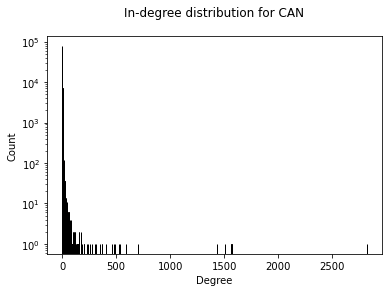

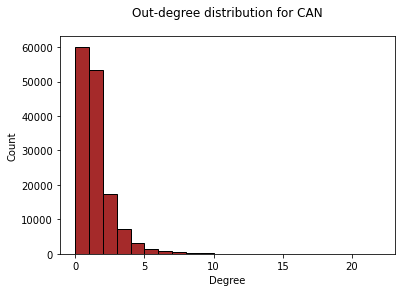

In [109]:
plt.title("In-degree distribution for CAN",pad = 20.0)
plt.hist(in_degree, bins = np.arange(np.min(in_degree), np.max(in_degree)+2),color = 'brown',edgecolor = 'k')
plt.ylabel("Count")
plt.xlabel("Degree")
plt.yscale('log')
plt.show()

plt.title("Out-degree distribution for CAN",pad = 20.0)
plt.hist(out_degree, bins = np.arange(np.min(out_degree), np.max(out_degree)+2),color = 'brown',edgecolor = 'k')
plt.ylabel("Count")
plt.xlabel("Degree")
plt.show()


In-degree distribution plotted using a log scale for the y axis.

In [110]:
dict_in_degree = dict(G.in_degree(G.nodes))
print("Top most in-degree connected users: ,", sorted(dict_in_degree, key=dict_in_degree.get, reverse=True)[:20])
dict_out_degree = dict(G.out_degree(G.nodes))
print("Top most out-degree connected users: ,", sorted(dict_out_degree, key=dict_out_degree.get, reverse=True)[:10])

Top most in-degree connected users: , ['realDonaldTrump', 'JustinTrudeau', 'YouTube', 'fordnation', 'CBCNews', 'globeandmail', 'CTVNews', 'torontostar', 'nationalpost', 'jkenney', 'TorontoStar', 'CP24', 'CNN', 'WHO', 'globalnews', 'CdnChange', 'CPHO_Canada', 'JohnTory', 'celliottability', 'CMOH_Alberta']
Top most out-degree connected users: , ['elizstiel', 'brandonkania', 'OttawaLionsTFC', 'EVENTSEMS', '_JeanLebel', 'SonuChotiB', 'AndrewStoeten', 'KMDLLP', 'pentictonman', 'scottjbaker']


**Visualization of Network**

100%|██████████| 2000/2000 [1:34:26<00:00,  2.83s/it]


BarnesHut Approximation  took  1817.73  seconds
Repulsion forces  took  3710.06  seconds
Gravitational forces  took  12.07  seconds
Attraction forces  took  7.90  seconds
AdjustSpeedAndApplyForces step  took  62.04  seconds


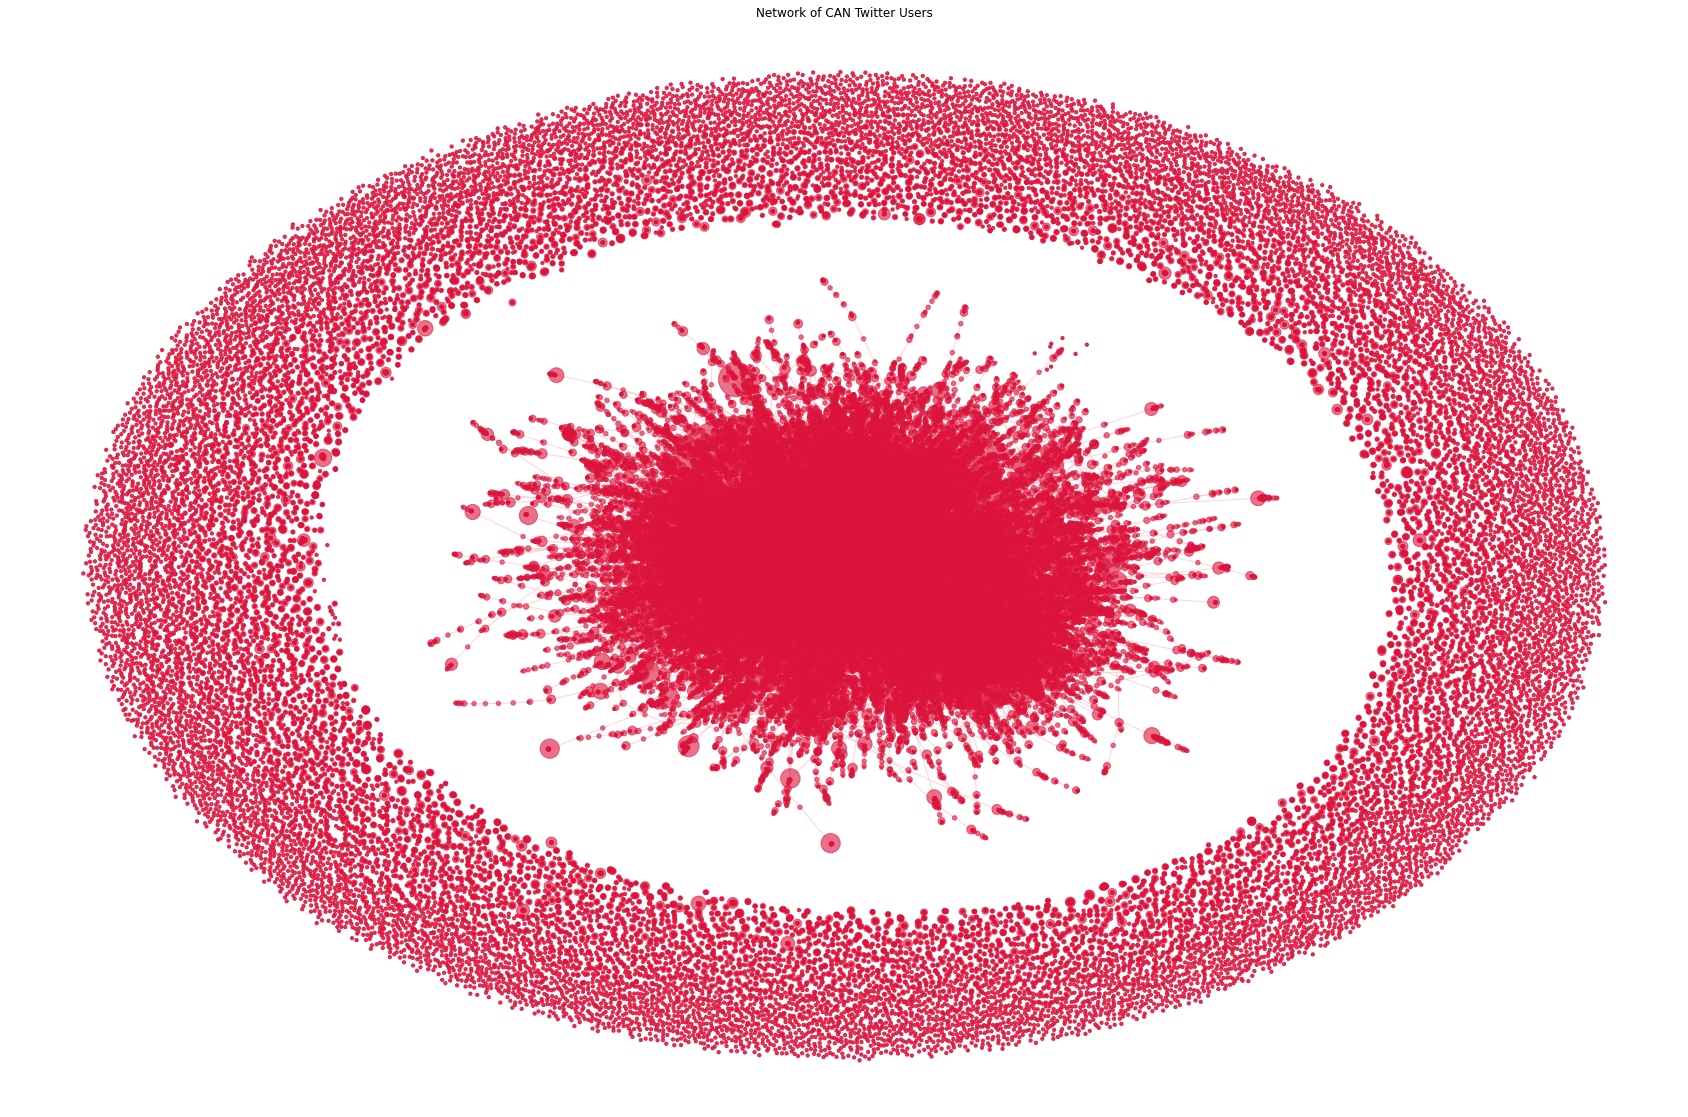

In [111]:
g = G.to_undirected()

# Get in-degrees in dict
degree_dict = dict(g.degree)

plt.figure(figsize = (30,20))

forceatlas2 = ForceAtlas2(
                        ## Behavior alternatives ##
                        outboundAttractionDistribution=False, # Dissuation
                        linLogMode=False,
                        adjustSizes=False, 
                        edgeWeightInfluence=1.0,

                        ## Performance ##
                        jitterTolerance=1.0,  # Tolerance level
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,

                        ## Tuning ##
                        scalingRatio=0.1,
                        strongGravityMode=False,
                        gravity=10.0,

                        ## Logging ##
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(g, pos=None, iterations=2000)

nx.draw_networkx(g, positions,nodelist=degree_dict.keys(), node_size=[v * 10 for v in degree_dict.values()], node_color = "#DC143C",alpha = 0.6, edge_color = '#FFB6C1',with_labels=False)

plt.axis('off')
plt.title('Network of CAN Twitter Users')
plt.show()

# Tweets analysis

Remove links from tweet:

In [112]:
def find_https(tweet):
    tweet =re.sub('\.*amp\.*', '', tweet.lower())
    return re.sub("(http|https)://[\w\-]+(\.[\w\-]+)+\S*",'', tweet)

In [113]:
data_df = data_df_test
data_df['tweet'] = data_df['tweet'].apply(find_https)

In [114]:
stop_words = set(stopwords.words('english'))
tokenizer = RegexpTokenizer(r'\w+') 

def tokenize_tweet(tweet):
    word_tokens = tokenizer.tokenize(tweet)
    filtered_sentence = [w.lower() for w in word_tokens if not w.lower() in stop_words and not w.lower() in ['corona', 'wuhan', 'ncov', 'covid', 'covid_19', 'covid19', 'coronavirus']]
    return filtered_sentence

In [115]:
data_df['tokens'] = data_df['tweet'].apply(tokenize_tweet)

In [116]:
def remove_mentions(x, y):
    for el in y:
        try:
            x.remove(el.lower())
        except:
            pass

In [117]:
data_df.apply(lambda x: remove_mentions(x['tokens'], x['mentions']), axis=1)

0         None
1         None
2         None
3         None
4         None
          ... 
229545    None
229546    None
229547    None
229548    None
229549    None
Length: 229550, dtype: object

# Identify communities

We use the unsupervised Louvain Algorithm for detecting communities:

In [118]:
partition = community.best_partition(g)

In [119]:
communities = np.unique(list(partition.values()))

The number of communities found is very large, however this was expected given the network also have numerous connections.

In [120]:
## Compute modularity for paritition ##

# Obtain representation of communities for nx_comm.modularity func
comms_dict = {}
for k, v in partition.items():
    str_v_ = str(v)
    if str_v_ not in comms_dict.keys():
        comms_dict[str_v_] = [k]
    else:
        comms_dict[str_v_].append(k)

comms_list = [v for k,v in comms_dict.items()]

M = nx_comm.modularity(g, comms_list)

print('Partition modularity : {}'.format(M))

Partition modularity : 0.9130806627158626


In [121]:
print("Number of found communities:")
print(max(communities))

comm_3_n = [i for i in comms_list if len(i) >=3]

print('Number of communities with more than 3 nodes: {}'.format(len(comm_3_n)))

Number of found communities:
22252
Number of communities with more than 3 nodes: 7150


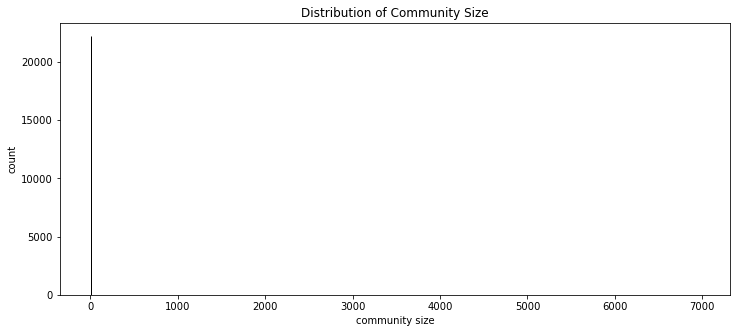

In [122]:
comms_sizes = [len(i) for i in comms_list]

plt.figure(figsize=(12,5))
plt.hist(comms_sizes,width=2,color='brown',edgecolor='k')
plt.xlabel('community size')
plt.ylabel('count')
plt.title('Distribution of Community Size')
plt.show()

In [123]:
d_input = dict(partition.items())
res = {}
for i, v in d_input.items():
    res[v] = [i] if v not in res.keys() else res[v] + [i]

Extracting the 10 largest communities only:

In [124]:
count = 0
largest_communities = sorted(res.items(), key=lambda v: len(v[1]), reverse=True)[:10]
texts = []

for i,t in enumerate(largest_communities):
    texts.append(np.concatenate(data_df.loc[data_df['username'].isin(t[1])]['tokens'].values))
    print(f"Community n. {i+1}. Size: {len(t[1])}")
    count += len(t[1])
    
print(f"\nAround {int(np.round(count/len(g.nodes), 2)*100)}% of network nodes is represented in these partitions.")

Community n. 1. Size: 6965
Community n. 2. Size: 5548
Community n. 3. Size: 4963
Community n. 4. Size: 3399
Community n. 5. Size: 3267
Community n. 6. Size: 2261
Community n. 7. Size: 2123
Community n. 8. Size: 1973
Community n. 9. Size: 1729
Community n. 10. Size: 1526

Around 23% of network nodes is represented in these partitions.


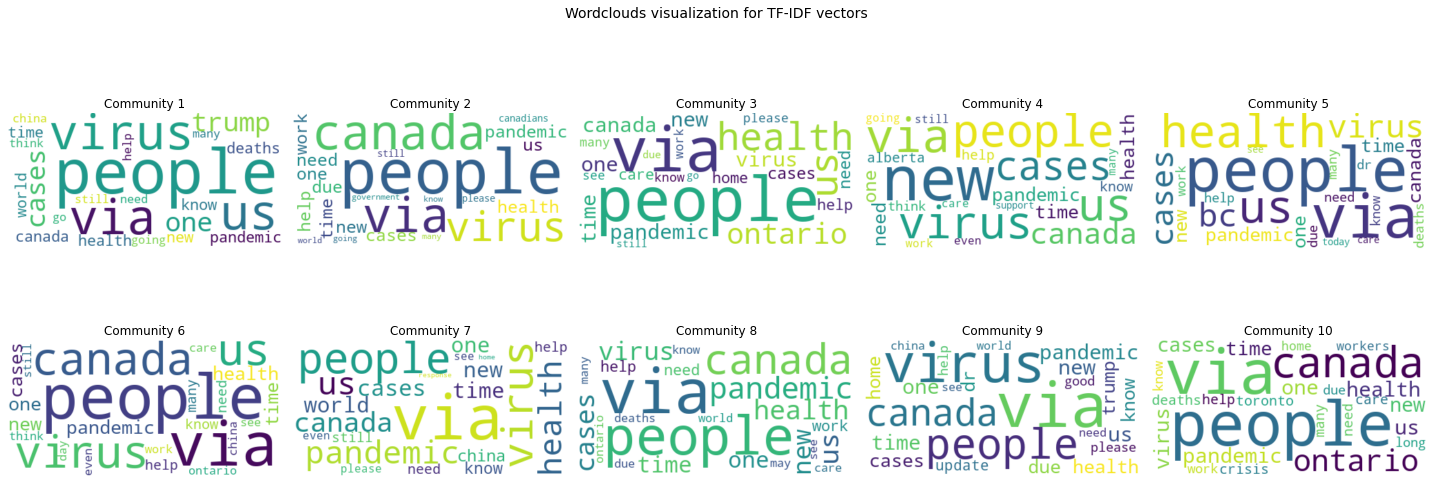

In [125]:
N = 10

# to calculate the tf:
tf_texts = pd.Series(texts).apply(nltk.FreqDist)

doc_freq = nltk.FreqDist(np.concatenate(pd.Series(texts).apply(lambda x: list(set(x))).values))

idf_values = np.log10((1+N/(1+np.array(list(doc_freq.values()))))) + 1

idf = dict(zip(doc_freq.keys(), idf_values))

def calculate_tf_idf(tf, idf):
    return dict(zip(list(tf.keys()), np.array(list(tf.values()))*np.array([idf.get(w) for w in list(tf.keys())])))

tf_idf_series = pd.Series(tf_texts).apply(lambda x: calculate_tf_idf(x, idf))

fig, ax = plt.subplots(2, 5, figsize= (20, 8))

c = 0
for i in range(2):
    for j in range(5):
        list_w = sorted(tf_idf_series[c], key=tf_idf_series[c].get, reverse=True)[:30]
        wordcloud = WordCloud(max_font_size=90, max_words=30, background_color="white").generate(" ".join(list_w))
        ax[i][j].imshow(wordcloud, interpolation="bilinear")
        ax[i][j].set_axis_off()
        ax[i][j].set_title(f"Community {c+1}")
        c += 1
fig.suptitle("Wordclouds visualization for TF-IDF vectors", fontsize = 14)
fig.tight_layout()
plt.show()

**Visualizing Community in Network**

In [126]:
# Reorganizing partition into dict structure
par_class = set(partition.values())
par_class_dict = {}

for v in partition.values():
    str_v = str(v)
    
    if str_v not in par_class_dict.keys():
        par_class_dict[str_v] = 1
    else:
        par_class_dict[str_v] += 1

In [127]:
# Getting top 10, again
par_class_dict = {k: v for k, v in sorted(par_class_dict.items(), key=lambda item: item[1],reverse = True)}
par_name_top10 = list(par_class_dict.keys())[:10]

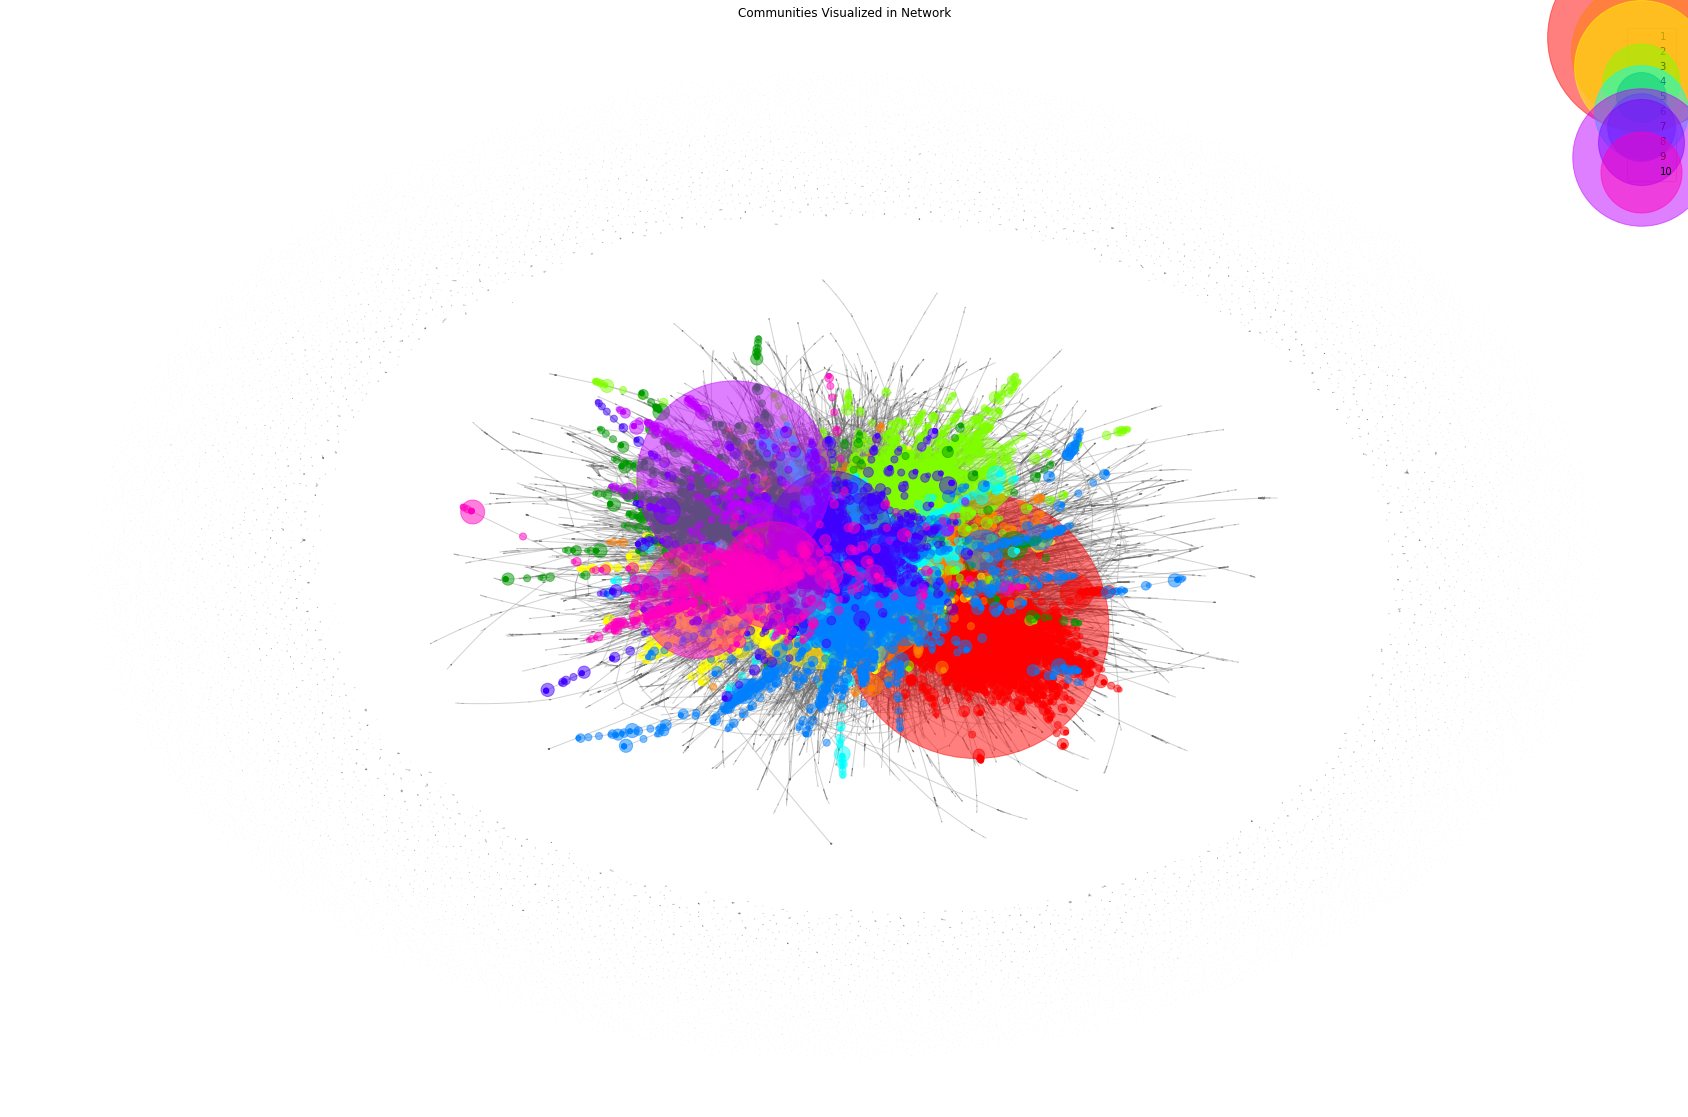

In [128]:
# Plot each community in network
plt.figure(figsize = (30,20))

nx.draw_networkx_edges(g,positions, alpha=0.3, edge_color = 'dimgray')

node_color_list = ['#ff0000','#ff8000','#ffff00','#80ff00',\
                   '#009900','#00ffff','#0080ff','#4000ff',\
                  '#bf00ff','#ff00bf']

for i,par_class in enumerate(par_name_top10):
    nodes = [n for n in list(g.nodes()) if partition[n] == int(par_class)]
    d = dict(g.degree(nodes))
    nx.draw_networkx_nodes(g, positions, d.keys(), node_size=[v*25 for v in d.values()],
                       node_color=node_color_list[i],alpha = 0.5,label =i+1)

plt.legend()   
plt.axis('off')
plt.title("Communities Visualized in Network")
plt.show()   

## Degree Centrality

To investigate degree centrality, we revert back to the directed version of the network graph.

In [129]:
# 5 most central characters according to degree centrality
in_degree_c = nx.in_degree_centrality(G)
out_degree_c = nx.out_degree_centrality(G)

# get the first 5 with in degree centrality
in_degree_c_sorted  = sorted(in_degree_c.items(),key = lambda x:x[1],reverse = True)
print('5 most central users (in degree centrality):\n{}'.format(in_degree_c_sorted[0:5]))
print('\n')

# get the first 5 with out degree centrality
out_degree_c_sorted  = sorted(out_degree_c.items(),key = lambda x:x[1],reverse = True)
print('5 most central users (out degree centrality):\n{}'.format(out_degree_c_sorted[0:5]))

5 most central users (in degree centrality):
[('realDonaldTrump', 0.019507435523047005), ('JustinTrudeau', 0.010850535260779604), ('YouTube', 0.010456096160100754), ('fordnation', 0.009909417406528313), ('CBCNews', 0.00484398895570518)]


5 most central users (out degree centrality):
[('elizstiel', 0.00014531966867115543), ('brandonkania', 0.00013839968444871945), ('OttawaLionsTFC', 0.00013147970022628347), ('EVENTSEMS', 0.00013147970022628347), ('_JeanLebel', 0.00013147970022628347)]


In [130]:
def plot_force_directed_graph(Graph, node_size_dict, fivemost_nodes, title_text, node_scale):
    """Make Force Atlas 2 directed graph plot of network with five most central nodes plotted.

        Args:
            Graph (NetworkX Graph object): NetworkX graph to plot.
            node_size_dict (dict): Dictionary of all nodes with value as node size and key for node name.
            fivemost_nodes (dict): Dictionary of five most central nodes with value as node size and key for node name.
            title_text (str): Title for plot.
            node_scale (int): Scaling factor for plotting the nodes.

    """
    
    plt.figure(figsize = (30,20))

    forceatlas2 = ForceAtlas2(
                        ## Behavior alternatives ##
                        outboundAttractionDistribution=False,  # Dissuation
                        linLogMode=False,
                        adjustSizes=False,
                        edgeWeightInfluence=1.0,

                        ## Performance ##
                        jitterTolerance=1.0, # Tolerance level
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,

                        ## Tuning ##
                        scalingRatio=0.1,
                        strongGravityMode=False,
                        gravity=10.0,

                        ## Logging ##
                        verbose=True)

    positions = forceatlas2.forceatlas2_networkx_layout(Graph, pos=None, iterations=2000)
    
    nx.draw_networkx(Graph, positions,nodelist=list(node_size_dict.keys()), node_size=[v * node_scale for v in node_size_dict.values()], alpha = 0.6,\
                        node_color = "#DC143C",edge_color = '#FFB6C1',with_labels=False)
    
    nx.draw_networkx_nodes(Graph, positions, nodelist=list(fivemost_nodes.keys()),node_size=[v * node_scale for v in fivemost_nodes.values()], \
                           alpha = 1, node_color="#DC143C",edgecolors ='black')
    labels = {}
    for node in fivemost_nodes.keys():
        labels[node] = node
    
    nx.draw_networkx_labels(Graph,positions,labels,font_size=18,font_color='k')
    
    plt.title(title_text,fontsize=28)
    plt.axis('off')
    plt.show()

100%|██████████| 2000/2000 [1:51:19<00:00,  3.34s/it]


BarnesHut Approximation  took  2411.21  seconds
Repulsion forces  took  4132.64  seconds
Gravitational forces  took  11.95  seconds
Attraction forces  took  6.01  seconds
AdjustSpeedAndApplyForces step  took  61.44  seconds


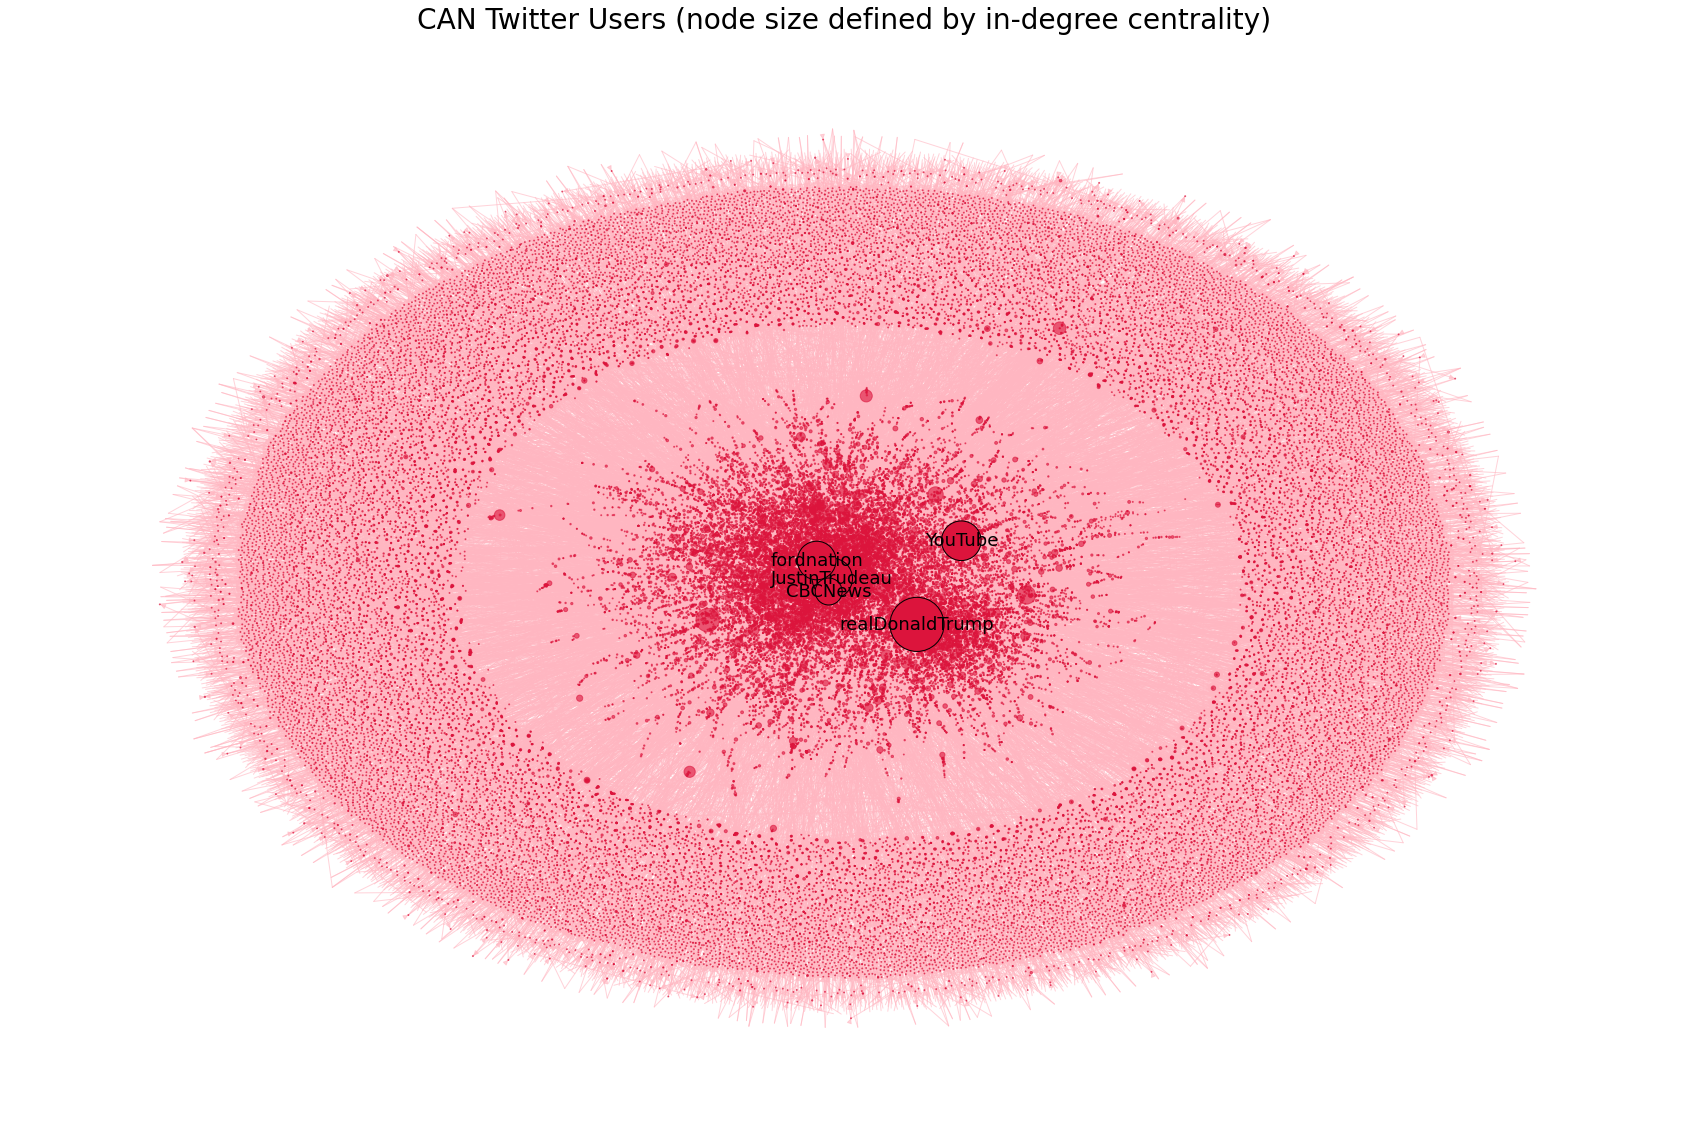

In [131]:
# Plot the network with in-degree centrality
in_degree_c_sorted = sorted(in_degree_c.items(),key = lambda x:x[1],reverse = True)
in_degree_c_sorted = dict(in_degree_c_sorted)
in_degree_c_sorted.update((x, y*10000) for x, y in in_degree_c_sorted.items())

# 5 most central users
nodes_ = list(in_degree_c_sorted)[0:5]
fivemost_nodes = {}
for i in nodes_:
    fivemost_nodes[i] = in_degree_c_sorted[i]

title_text = 'CAN Twitter Users (node size defined by in-degree centrality)'

plot_force_directed_graph(G, in_degree_c_sorted,fivemost_nodes,title_text, 15)

100%|██████████| 2000/2000 [2:00:45<00:00,  3.62s/it]  


BarnesHut Approximation  took  2569.05  seconds
Repulsion forces  took  4540.65  seconds
Gravitational forces  took  12.03  seconds
Attraction forces  took  6.00  seconds
AdjustSpeedAndApplyForces step  took  61.34  seconds


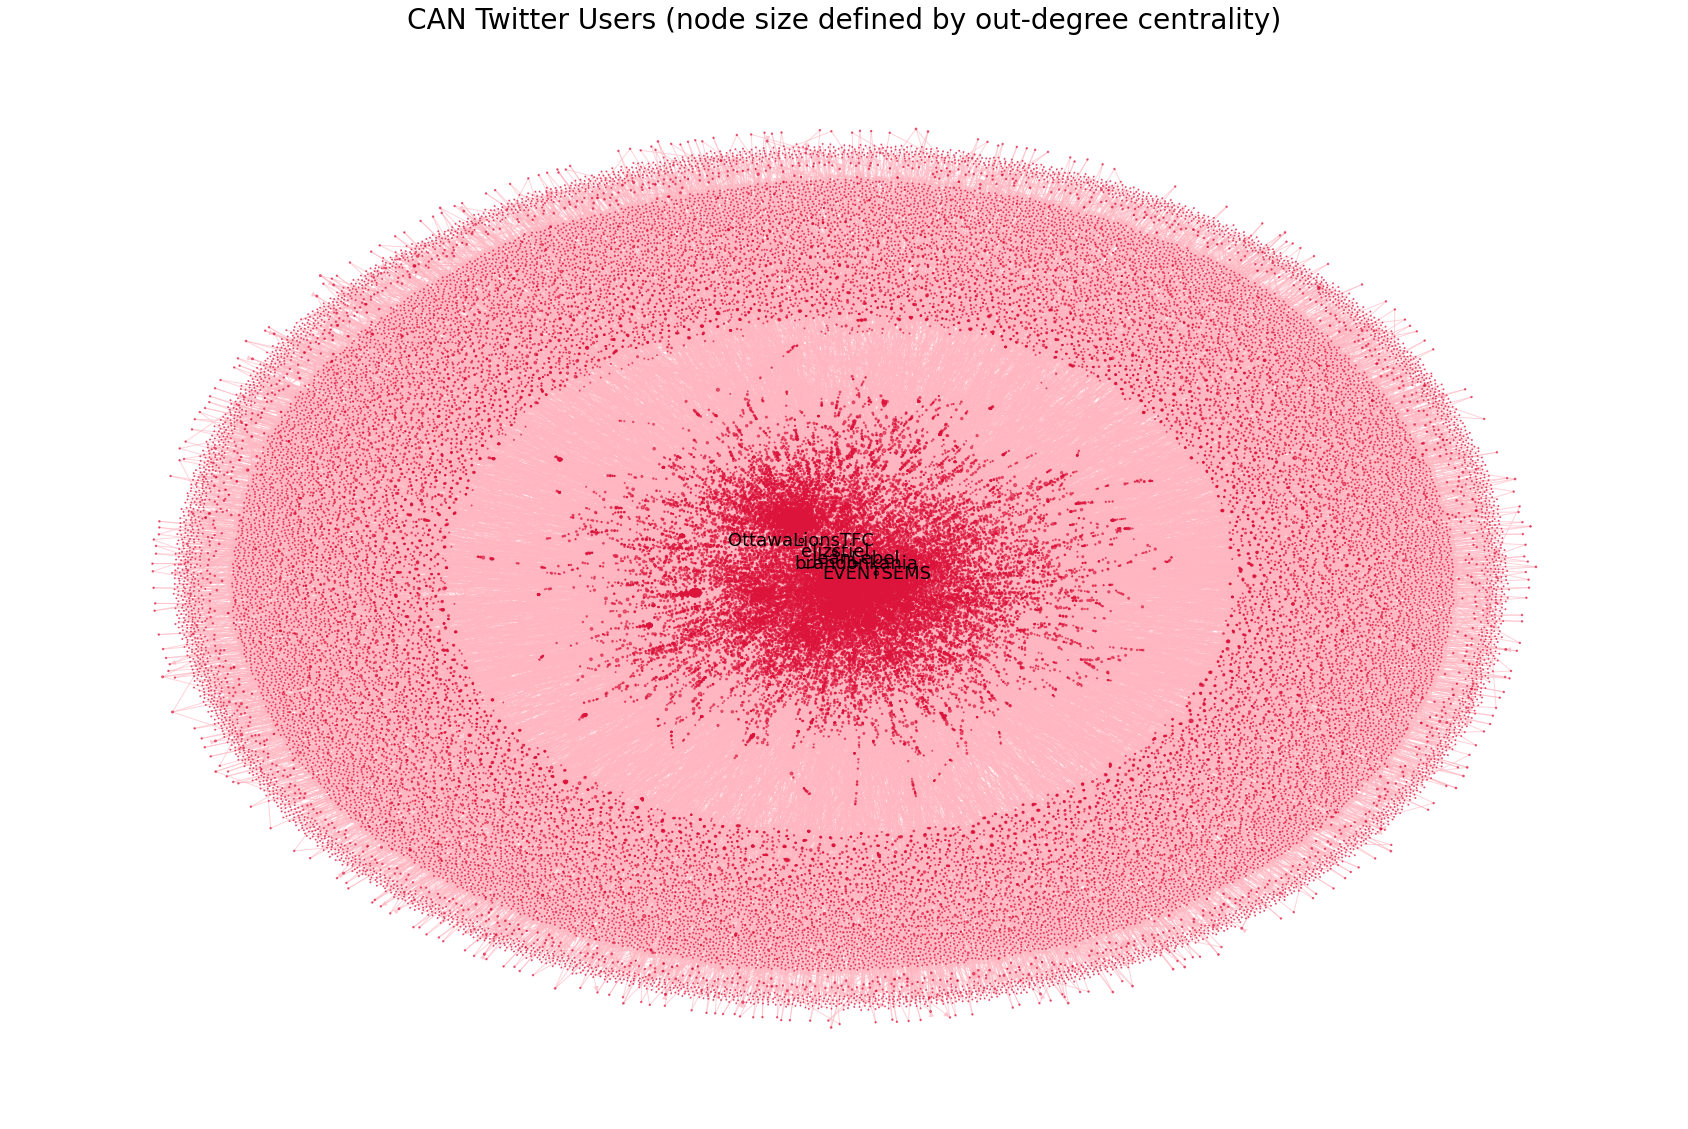

In [132]:
# Plot the network with out-degree centrality
out_degree_c_sorted = sorted(out_degree_c.items(),key = lambda x:x[1],reverse = True)
out_degree_c_sorted = dict(out_degree_c_sorted)
out_degree_c_sorted.update((x, y*10000) for x, y in out_degree_c_sorted.items())

# 5 most central users
nodes_ = list(out_degree_c_sorted)[0:5]

fivemost_nodes = {}
for i in nodes_:
    fivemost_nodes[i] = out_degree_c_sorted[i]

title_text = 'CAN Twitter Users (node size defined by out-degree centrality)'

plot_force_directed_graph(G, out_degree_c_sorted,fivemost_nodes,title_text, 15)

**Betweenness Centrality for Undirected Graph**

In [143]:
# Extract largest component
gcc = max(nx.weakly_connected_components(G), key=len)
gcc_subgraph = G.subgraph(gcc)
gcc_visualize = gcc_subgraph.to_undirected()

In [144]:
between_c = nx.betweenness_centrality(gcc_visualize)

# the 5 most central characters according to betweenness centrality
bet_c_sorted  = sorted(between_c.items(),key = lambda x:x[1],reverse = True)
print('5 most central characters (betweenness centrality):\n{}'.format(bet_c_sorted[0:5]))
print('\n')

5 most central characters (betweenness centrality):
[('realDonaldTrump', 0.258973649390477), ('JustinTrudeau', 0.20825741987096355), ('fordnation', 0.14548230436703116), ('CBCNews', 0.07089318384362862), ('YouTube', 0.06233845476608961)]




In [145]:
# Scale for better plotting
bet_c_sorted = dict(bet_c_sorted)
bet_c_sorted.update((x, y*100000) for x, y in between_c.items())

100%|██████████| 2000/2000 [1:47:05<00:00,  3.21s/it]


BarnesHut Approximation  took  2522.14  seconds
Repulsion forces  took  3765.82  seconds
Gravitational forces  took  11.53  seconds
Attraction forces  took  9.17  seconds
AdjustSpeedAndApplyForces step  took  60.49  seconds


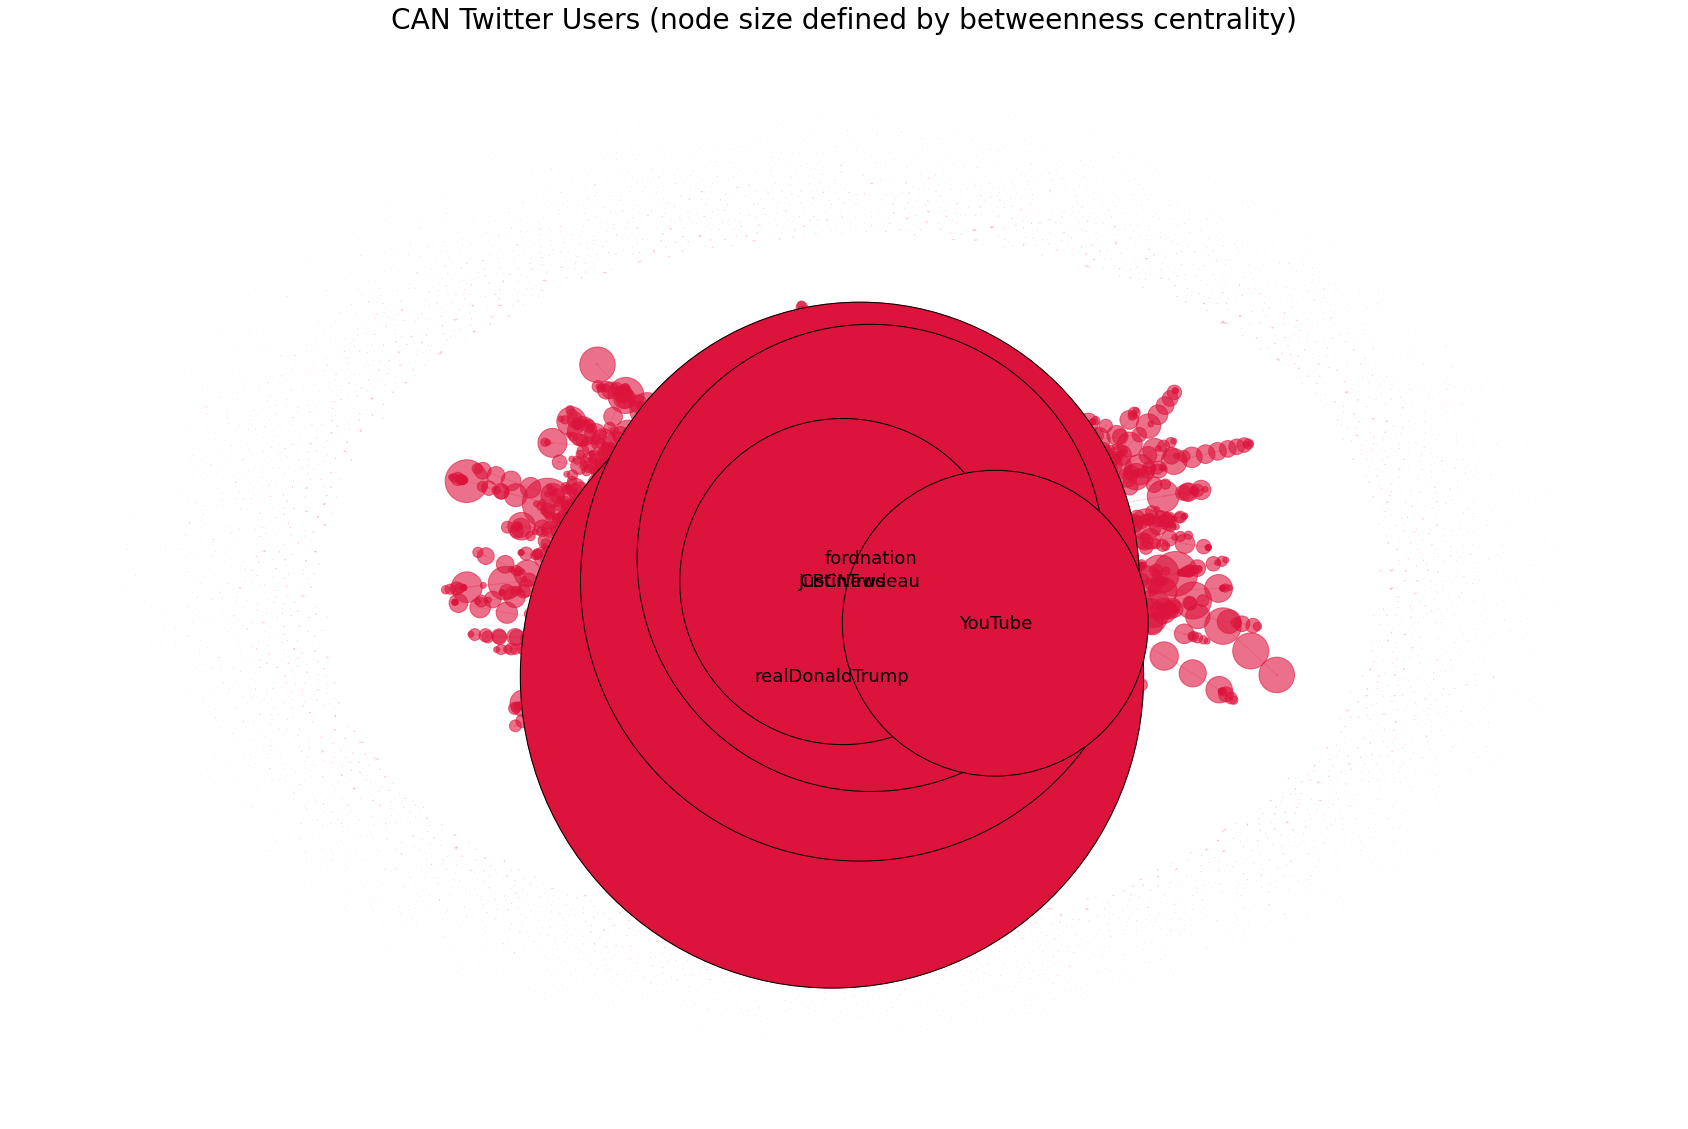

In [146]:
# 5 most central users
nodes_ = list(bet_c_sorted)[0:5]
fivemost_nodes = {}

for i in nodes_:
    fivemost_nodes[i] = bet_c_sorted[i]

plot_force_directed_graph(g, bet_c_sorted, fivemost_nodes,\
                          'CAN Twitter Users (node size defined by betweenness centrality)', 15)

**How are nodes linked?**

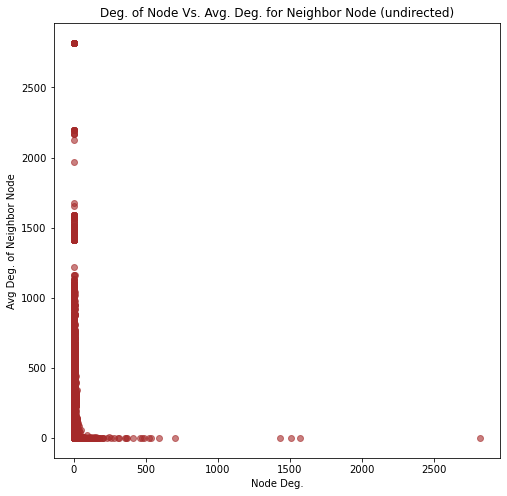

In [147]:
# undirected marvel network
avg_neigh_degrees = nx.average_neighbor_degree(g)

# plot
plt.figure(figsize=(8,8))
plt.scatter(dict(g.degree()).values(),avg_neigh_degrees.values(),c= 'brown',alpha=0.6)
plt.title('Deg. of Node Vs. Avg. Deg. for Neighbor Node (undirected)')
plt.xlabel('Node Deg.')
plt.ylabel('Avg Deg. of Neighbor Node')
plt.show()

In [150]:
data_df['tweet_timestamp'] = pd.to_datetime(data_df['tweet_timestamp'], format='%Y-%m-%d %H:%M:%S')

In [151]:
start_date = '2020-03-02 00:00:00.000000000'
end_date = '2020-03-22 00:00:00.000000000'
initial_phase_idx = np.where(data_df['tweet_timestamp'].between(start_date,end_date))[0]

In [152]:
start_date = '2020-03-31 00:00:00.000000000'
end_date = '2020-04-13 00:00:00.000000000'
peak_idx = np.where(data_df['tweet_timestamp'].between(start_date,end_date))[0]

In [153]:
start_date = '2020-07-02 00:00:00.000000000'
end_date = '2020-07-21 00:00:00.000000000'
final_phase_idx = np.where(data_df['tweet_timestamp'].between(start_date,end_date))[0]

In [154]:
texts_phases = []
for idx in [initial_phase_idx, peak_idx, final_phase_idx]:
    texts_phases.append(np.concatenate(data_df.iloc[idx].copy().loc[:, 'tokens'].values))

In [157]:
def calculate_tf_idf(tf, idf):
    return dict(zip(list(tf.keys()), np.array(list(tf.values()))*np.array([idf.get(w) for w in list(tf.keys())])))

def return_tf_idf(texts, n_communities):
   
    # to calculate the term frequency for each document:
    texts = pd.Series(texts)
    tf_texts = texts.apply(nltk.FreqDist)

    #to calculate document frequency
    doc_freq = nltk.FreqDist(np.concatenate(texts.apply(lambda x: list(set(x))).values))
    
    #to calculate the inverse document frequency
    idf_values = np.log10((1+n_communities)/(1+np.array(list(doc_freq.values())))) + 1
    idf = dict(zip(doc_freq.keys(), idf_values))

    tf_idf_series = pd.Series(tf_texts).apply(lambda x: calculate_tf_idf(x, idf))
    
    return tf_idf_series

In [158]:
tf_idf_phases = return_tf_idf(texts_phases, 3)

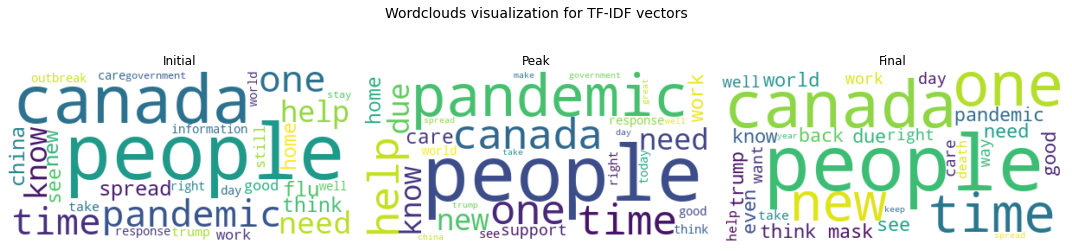

In [159]:
fig, ax = plt.subplots(1,3, figsize= (15, 4))

phases = ['Initial', 'Peak', 'Final']
for i in range(3):
    list_w = sorted(tf_idf_phases[i], key=tf_idf_phases[i].get, reverse=True)
    wordcloud = WordCloud(max_font_size=90, max_words=30, background_color="white").generate(" ".join(list_w))
    ax[i].imshow(wordcloud, interpolation="bilinear")
    ax[i].set_axis_off()
    ax[i].set_title(f"{phases[i]}")
fig.suptitle("Wordclouds visualization for TF-IDF vectors", fontsize = 14)
fig.tight_layout()
plt.show()

In [160]:
def dispersion_plot(text, words, ignore_case=False, title="Lexical Dispersion Plot"):
    """
    Generate a lexical dispersion plot.

    :param text: The source text
    :type text: list(str) or enum(str)
    :param words: The target words
    :type words: list of str
    :param ignore_case: flag to set if case should be ignored when searching text
    :type ignore_case: bool
    """

    try:
        from matplotlib import pylab
    except ImportError as e:
        raise ValueError(
            "The plot function requires matplotlib to be installed."
            "See https://matplotlib.org/"
        ) from e

    text = list(text)
    words.reverse()

    if ignore_case:
        words_to_comp = list(map(str.lower, words))
        text_to_comp = list(map(str.lower, text))
    else:
        words_to_comp = words
        text_to_comp = text

    points = [
        (x, y)
        for x in range(len(text_to_comp))
        for y in range(len(words_to_comp))
        if text_to_comp[x] == words_to_comp[y]
    ]
    if points:
        x, y = list(zip(*points))
    else:
        x = y = ()
    pylab.plot(x, y, "b|", scalex=0.1)
    pylab.yticks(list(range(len(words))), words, color="b")
    pylab.ylim(-1, len(words))
    pylab.title(title)
    pylab.xlabel("Word Offset")
    pylab.show()

In [161]:
all_texts = np.concatenate(data_df.copy().loc[:, 'tokens'].values)

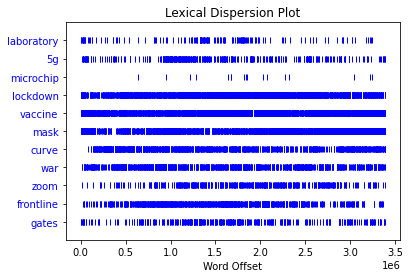

In [162]:
dispersion_plot(all_texts,["laboratory", "5g", "microchip", 'lockdown', 'vaccine', 'mask', 'curve', 'war', 'zoom', 'frontline', 'gates'])

In [184]:
can_deaths = pd.read_csv('data/canada/files/owid-covid-data.csv')
can_deaths = can_deaths.loc[can_deaths['location'] == 'Canada']
can_deaths = can_deaths.reset_index(drop=True)
can_deaths['date'] = pd.to_datetime(can_deaths['date'], format='%Y-%m-%d')
can_deaths = can_deaths[can_deaths['date'].between("2020-03-02" ,"2020-07-22")].iloc[::-1]
can_deaths = can_deaths.reset_index(drop=True)
can_deaths = can_deaths.reindex(index=can_deaths.index[::-1])
can_deaths = can_deaths.reset_index(drop=True)
#calculate sum of values, grouped by week
can_deaths = can_deaths.groupby([pd.Grouper(key='date', freq='W')])['new_cases'].sum()


date
2020-03-08       82.0
2020-03-15      429.0
2020-03-22     2103.0
2020-03-29     5594.0
2020-04-05     9353.0
2020-04-12     9367.0
2020-04-19    12351.0
2020-04-26    11390.0
2020-05-03    10933.0
2020-05-10     8942.0
2020-05-17     8112.0
2020-05-24     7409.0
2020-05-31     5964.0
2020-06-07     4150.0
2020-06-14     2891.0
2020-06-21     2541.0
2020-06-28     2329.0
2020-07-05     1904.0
2020-07-12     2122.0
2020-07-19     3022.0
2020-07-26     1637.0
Freq: W-SUN, Name: new_cases, dtype: float64

In [195]:
subset_can = data_df[data_df['tweet_timestamp'].between("2020-03-08", "2020-07-19")]

In [196]:
frequency = subset_can['tokens'].apply(nltk.FreqDist)

In [197]:
freq_df = subset_can.copy()[['tweet_timestamp']].join(frequency)

In [198]:
def weekly_freq(freq_df, words, deaths):
    fig, ax = plt.subplots()

    for w in words:
        freq_df[w] = freq_df['tokens'].apply(lambda x: x.get(w, 0))
        freq_df[w] = freq_df[w] + freq_df['tokens'].apply(lambda x: x.get(w+'s', 0))
        y = freq_df.groupby(pd.Grouper(freq='W', key='tweet_timestamp'))[w].sum()
        x = np.arange(len(y.values))
      
        plt.plot(x, y.values, label = w)

    plt.xticks(np.arange(0, max(x+1), 1), rotation=45)
    plt.axvline(np.argmax(deaths), label = 'peak', color = 'black', linestyle = 'dotted')
    labels = freq_df.groupby(pd.Grouper(freq='W', key='tweet_timestamp'))[w].sum().index
    labels = pd.Series(labels).apply(lambda x: x.strftime("%d-%b-%Y"))
    ax.set_xticklabels(labels)
    for tick in ax.xaxis.get_majorticklabels():
        tick.set_horizontalalignment("right")
    ax.set_title("Comparison of words frequency over time")
    leg = ax.legend()  

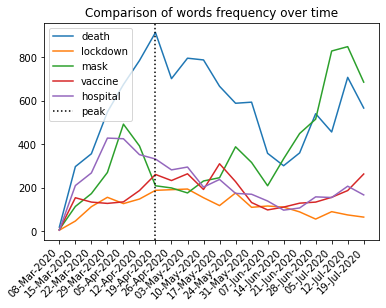

In [199]:
weekly_freq(freq_df, ['death', 'lockdown', 'mask', 'vaccine', 'hospital'], list(can_deaths))

**Check Peak/bottom Tweets**

In [202]:
# 
tweets_sents = pd.read_csv("data/canada/files/CAN_sentiment.csv",index_col=0)

In [203]:
tweets_sents_pos = tweets_sents.sort_values(by=['sentiment_score'], ascending=False)

In [204]:
tweets_sents_neg = tweets_sents.sort_values(by=['sentiment_score'])

In [205]:
print("**Top 5 positive tweets**")

for i in range(0,5):
    print(" ")
    print("Tweet:")
    print(tweets_sents_pos["tweet"].iloc[i])

**Top 5 positive tweets**
 
Tweet:
@iam_sidrah Corona love
 
Tweet:
@gggg45466 @white_queen31 Covid love ? 💋
 
Tweet:
@StephenKing Forbidden corona love
 
Tweet:
Cool 
Rainy 
Covid-19 
Stay healthy
 
Tweet:
@sunlorrie The Leafs Covid Cup celebration.


In [206]:
print("**Top 5 negative tweets**")

for i in range(0,5):
    print(" ")
    print("Tweet:")
    print(tweets_sents_neg["tweet"].iloc[i])

**Top 5 negative tweets**
 
Tweet:
Corona Almond Whirl  #OddDoughnutFlavours
 
Tweet:
COVID-19 DOESN’T GIVE YOU DIARRHEA #CoronaVirusCanada #ToiletPaperApocalypse
 
Tweet:
I WILL MURDER COVID-19 WITH MY BARE HANDS IF THE POST IS STILL DOWN BY THE END OF MAY
 
Tweet:
@catsockies covid-19
 
Tweet:
$AAPL IS REOPENING STORES IN THE #US NEXT WEEK. #Covid_19
